# Variational Auto Encoder from *Auto-Encoding Variational Bayes*

In [31]:
import keras
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [47]:
def vae(Xtrain, nndim = 200, latentdim = int(2), samplestd = 1.0,
        epochs = int(10), batch_size = int(100)):
    inputdim = Xtrain.shape[1]
    """define an auto-encoder following AEVB"""
    
    if inputdim <= nndim or inputdim <= latentdim:
        print("overspecified model")
        return -1
    
    if batch_size > Xtrain.shape[0]:
        print("too large batch size")
        return -1
    
    if epochs < 1:
        print("must have at least one epoch")
        return -1
    
    X = keras.layers.Input(shape = (inputdim,))
    Xinv = keras.layers.Dense(units = inputdim, activation = "sigmoid")
    Q = keras.layers.Dense(object = X, units = nndim, activation = "relu")
    Qinv = keras.layers.Dense(units = nndim, activation = "relu")
    
    Zm = keras.layers.Dense(object = Q, units = latentdim, activation = "linear")
    Zv = keras.layers.Dense(object = Q, units = latentdim, activation = "linear")
    
    def lam(det):
        """lambda for keras"""
        Zm = det[:, range(latentdim)]
        Zv = det[:, range(latentdim+1,2*latentdim)]
        noise = keras.backend.random_normal(shape = keras.shape(Zm)[0],
                                           mean = 0,
                                           stddev=samplestd)
        return Zm + noise * keras.backend.sqrt(keras.backend.exp(Zv))
    
    Z = keras.layers.Lambda(keras.layers.Concatenate([Zm, Zv]), lam)
    
    Zgen = keras.layers.Input(shape = latentdim)
    
    Qout = Qinv(Z)
    Xout = Xinv(Qout)
    
    Qgen = Qinv(Zgen)
    Xgen = Xinv(Qgen)
    
    autoencoder = keras.Model(X, Xout)
    encoder = keras.Model(X, Zm)
    decoder = keras.Model(Zgen, Xgen)
    
    l= 1.0
    
    def AEVBloss(X, Xout):
        """Loss from Auto-Encoding Variational Bayes page 5"""
        decterm = (inputdim/l) * keras.losses.binary_crossentropy(X, Xout)
        KLterm = -0.5 * keras.backend.mean(1 + Zv - 
                                           keras.backend.square(Zm) - 
                                          keras.backend.exp(Zv),
                                          axis = -1)
        return KLterm + decterm
    
    
    autoencoder.compile(optimizer = "rmsprop", loss = AEVBloss)
    
    autoencoder.fit(x = Xtrain, y = Xtrain, epochs = epochs, batch_size = batch_size)
    
    return([autoencoder, encoder, decoder])

In [33]:
from keras.datasets import mnist
mnist.load_data()

11493376/11490434 [==============================] - 6s 0us/step


((array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         ...,
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0

In [5]:
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()

In [36]:
Xtrain.shape

(60000, 28, 28)

In [6]:
Xtrain = Xtrain.reshape(60000, 784)

In [7]:
Xtrain = Xtrain / 255

In [21]:
output = vae2(Xtrain, nndim = 200, latentdim = int(2), samplestd = 1.0,
        epochs = int(10), batch_size = int(100))

Epoch 1/10
60000/60000 [==============================] - 6s 107us/step - loss: 200.7069
Epoch 2/10
60000/60000 [==============================] - 6s 96us/step - loss: 166.0605
Epoch 3/10
60000/60000 [==============================] - 7s 109us/step - loss: 163.3117
Epoch 4/10
60000/60000 [==============================] - 6s 103us/step - loss: 161.5662
Epoch 5/10
60000/60000 [==============================] - 6s 105us/step - loss: 160.1262
Epoch 6/10
60000/60000 [==============================] - 6s 107us/step - loss: 158.8283
Epoch 7/10
60000/60000 [==============================] - 6s 107us/step - loss: 157.5646
Epoch 8/10
60000/60000 [==============================] - 7s 114us/step - loss: 156.3692
Epoch 9/10
60000/60000 [==============================] - 6s 107us/step - loss: 155.2694
Epoch 10/10
60000/60000 [==============================] - 6s 108us/step - loss: 154.3058


In [22]:
autoencoder, encoder, decoder = output

In [28]:
Xtest = Xtest.reshape((len(Xtest), np.prod(Xtest.shape[1:])))

In [29]:
x_test_encoded = encoder.predict(Xtest/255, batch_size = int(100))

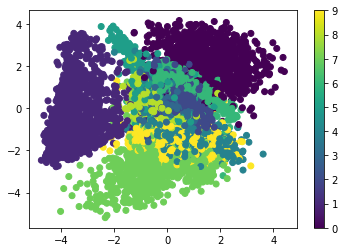

In [33]:
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=ytest)
plt.show()

In [20]:
#### Michael's poor attempt
def vae2(Xtrain, nndim = 200, latentdim = int(2), samplestd = 1.0,
        epochs = int(10), batch_size = int(100)):

    inputdim = Xtrain.shape[1]
    """define an auto-encoder following AEVB"""

    X = keras.layers.Input(shape = (inputdim,))
    Q = keras.layers.Dense(units = nndim, activation = "relu")(X)
    Zm = keras.layers.Dense(units = latentdim)(Q)
    Zv = keras.layers.Dense(units = latentdim)(Q)

    def lam(det):
        """lambda for keras"""
        Zm, Zv = det
        noise = keras.backend.random_normal(shape = (batch_size, latentdim),
                                       mean = 0.0,
                                       stddev=samplestd)
        return Zm + noise * keras.backend.exp(Zv)

    Z = keras.layers.Lambda(lam, output_shape = (latentdim,))([Zm, Zv])

    Qinv = keras.layers.Dense(units = nndim, activation = "relu")
    Xinv = keras.layers.Dense(units = inputdim, activation = "sigmoid")
    Qout = Qinv(Z)
    Xout = Xinv(Qout)


    ### Generating from latent space
    Zgen = keras.layers.Input(shape = (latentdim,))
    Qgen = Qinv(Zgen)
    Xgen = Xinv(Qgen)

    ### Defining the 3 models
    autoencoder = keras.Model(X, Xout)
    encoder = keras.Model(X, Zm)
    decoder = keras.Model(Zgen, Xgen)


    l= 1.0

    ### Creation of loss function
    def AEVBloss(X, Xout):
        """Loss from Auto-Encoding Variational Bayes page 5"""
        decterm = (inputdim/l) * keras.losses.binary_crossentropy(X, Xout) 
        KLterm = -0.5 * keras.backend.mean(1 + Zv - 
                                       keras.backend.square(Zm) - 
                                      keras.backend.exp(Zv),
                                      axis = -1)
        return KLterm + decterm


    autoencoder.compile(optimizer = "rmsprop", loss = AEVBloss)

    autoencoder.fit(x = Xtrain, y = Xtrain, epochs = epochs, batch_size = batch_size)

    return([autoencoder, encoder, decoder])
